
## Chemo-mechanical model

**The case of equipotential CCs**


The model for specified-current (dis)charge in Anode is given by
\begin{equation} \frac{d{C_a}}{dt} = -{\frac{I}{FAL_an_a}}\\
 \Psi_a = U_{\text{eq,a}} + \frac{1}{F |\Gamma_{\text{inc,a}}|} \left( V_a \int_{\Gamma_{\text{inc,a}}} S^{p}_{\text{a,surf}} dS_a  + \frac{2RT I}{A L_a n_a K_a C_a^{1/2} (C_{\text{a,max}}-C_a)^{1/2}} \right)\\
 \eta_a = \Psi_a - U_{\text{eq,a}} - \frac{V_a}{F} S^{p}_{\text{a,surf}},\\
 S^{p}_{\text{a,surf}} = S^{p}_{\text{a,surf}}(g_a),\\
\frac{4}{3} \pi R_a^3 \left( (1+g_a)^3 - 1 \right) = V_a \left( C_a - C_{a,\text{ref}} \right),
\end{equation}
and in cathode is given by

\begin{equation}
\frac{d{C_a}}{dt} = -{\frac{I}{FAL_cn_c}}\\
 \Psi_a = U_{\text{eq,c}} + \frac{1}{F |\Gamma_{\text{inc,c}}|} \left( V_c \int_{\Gamma_{\text{inc,c}}} S^{p}_{\text{c,surf}} dS_c  + \frac{2RT I}{A L_c n_c K_c C_c^{1/2} (C_{\text{c,max}}-C_c)^{1/2}} \right)\\
 \eta_c = \Psi_c- U_{\text{eq,c}} - \frac{V_c}{F} S^{p}_{\text{c,surf}},\\
 S^{p}_{\text{a,surf}} = S^{p}_{\text{a,surf}}(g_c),\\
\frac{4}{3} \pi R_c^3 \left( (1+g_c)^3 - 1 \right) = V_c \left( C_c - C_{c,\text{ref}} \right),
\end{equation}

**Total cell Voltage**


\begin{equation}
V_{\text{SPM}} = \left( \eta_{c} + U_{\text{eq,c}} + \frac{V_c}{F} S^p_{\text{surf},c} \right) - \left( \eta_{a} + U_{\text{eq,a}} + {\frac{V_a}{F} S^p_{\text{surf},a}} \right) - I \frac{{\mathcal L}}{\sigma}.
\end{equation}


Here we are solving single particle and chemomechanical models for three C-rates
1.   1C - crate charge
2.   C/5, 1C and 2C C-rates Charge
3.   Charge for half an hour with 1C C-rate and then rest for half an hour



## Setting up the model
We begin by importing the pybamm library into this notebook, along with any other packages we require.

In [ ]:
%pip install pybamm -q    # install PyBaMM if it is not installed
import pybamm
import numpy as np
import matplotlib.pyplot as plt

## PyBaMM Submodule for our problem
**Creating chemo-mechanical model with linear BV equations**

In [ ]:
from numpy import pi


class InverseButlerVolmer(pybamm.interface.BaseInterface):
    """
    A submodel that implements the inverted form of the Butler-Volmer relation to
    solve for the reaction overpotential.
    Parameters
    ----------
    param
        Model parameters
    domain : iter of str, optional
        The domain(s) in which to compute the interfacial current.
    reaction : str
        The name of the reaction being implemented
    options: dict
        A dictionary of options to be passed to the model. In this case "SEI film
        resistance" is the important option. See :class:`pybamm.BaseBatteryModel`
    **Extends:** :class:`pybamm.interface.BaseInterface`
    """

    def __init__(self, param, domain, reaction, options=None):
        super().__init__(param, domain, reaction, options=options)

    def get_coupled_variables(self, variables):
        domain, Domain = self.domain_Domain
        reaction_name = self.reaction_name

        ocp = variables[f"{Domain} electrode {reaction_name}open circuit potential"]

        j0 = self._get_exchange_current_density(variables)
        j_tot_av, a_j_tot_av = self._get_average_total_interfacial_current_density(
            variables
        )
        # Broadcast to match j0's domain
        if j0.domain in [[], ["current collector"]]:
            j_tot = j_tot_av
        else:
            j_tot = pybamm.PrimaryBroadcast(j_tot_av, [f"{domain} electrode"])
        variables.update(
            self._get_standard_total_interfacial_current_variables(j_tot, a_j_tot_av)
        )

        # Note: T and u must have the same domain as j0 and eta_r
        if self.options.electrode_types[domain] == "planar":
            T = variables["X-averaged cell temperature"]
            u = variables["Lithium metal interface utilisation"]
        elif j0.domain in ["current collector", ["current collector"]]:
            T = variables["X-averaged cell temperature"]
            u = variables[f"X-averaged {domain} electrode interface utilisation"]
        else:
            T = variables[f"{Domain} electrode temperature"]
            u = variables[f"{Domain} electrode interface utilisation"]

        # eta_r is the overpotential from inverting Butler-Volmer, regardless of any
        # additional resistance (e.g. SEI). What changes is how delta_phi is defined
        # in terms of eta_r
        ne = self._get_number_of_electrons_in_reaction()
        eta_r = self._get_overpotential(j_tot, j0, ne, T, u)

        # With SEI resistance (distributed and averaged have the same effect here)
        if self.domain == "negative":
            if self.options["SEI film resistance"] != "none":
                R_sei = self.phase_param.R_sei
                if self.options.electrode_types["negative"] == "planar":
                    L_sei = variables["Total SEI thickness"]
                else:
                    L_sei = variables["X-averaged total SEI thickness"]
                eta_sei = -j_tot * L_sei * R_sei
            # Without SEI resistance
            else:
                eta_sei = pybamm.Scalar(0)
            variables.update(
                self._get_standard_sei_film_overpotential_variables(eta_sei)
            )
        else:
            eta_sei = pybamm.Scalar(0)

        # add "mechanics overpotential"
        c = variables[f"{Domain} particle surface concentration [mol.m-3]"]
        eta_m = self._get_mechanics_overpotential(c)

        # define surface potential difference
        delta_phi = eta_m + eta_r + ocp - eta_sei  # = phi_s - phi_e

        variables.update(self._get_standard_exchange_current_variables(j0))
        variables.update(self._get_standard_overpotential_variables(eta_r))
        variables.update(
            self._get_standard_average_surface_potential_difference_variables(
                pybamm.x_average(delta_phi)
            )
        )

        return variables

    def _get_overpotential(self, j, j0, ne, T, u):
        # Linearised Butler-Volmer
        return (2 * (1 + self.param.Theta * T) / ne) * (j / (2 * j0 * u))

    def _get_mechanics_overpotential(self, c):
        _, Domain = self.domain_Domain
        param = self.param
        pot_scale = param.potential_scale  # potential scale [V]
        F = param.F  # Faraday constant [C.mol-1]
        Omega = self.domain_param.Omega  # partial molar volume [m3.mol-1]
        mu = pybamm.Parameter(f"{Domain} electrode Lame parameter [Pa]")
        R = self.phase_param.R_dimensional  # particle radius [m]
        Gamma_int = 4 * pi * R**2  # surface area [m2]
        nu = mu * Omega / F / pot_scale

        c_max = self.phase_param.c_max
        S_tot_dim = pybamm.FunctionParameter(
            f"{Domain} electrode volumetric stress [Pa]",
            {"Concentration [mol.m-3]": c, "Maximum concentration [mol.m-3]": c_max},
        )
        S_tot = S_tot_dim / mu / Gamma_int

        return nu * S_tot


class MSPM(pybamm.lithium_ion.SPM):
    """
    Single Particle Model of a lithium-ion battery from [1]_, with mechanics.
    Parameters
    ----------
    options : dict, optional
        A dictionary of options to be passed to the model. For a detailed list of
        options see :class:`~pybamm.BatteryModelOptions`.
    name : str, optional
        The name of the model.
    build :  bool, optional
        Whether to build the model on instantiation. Default is True. Setting this
        option to False allows users to change any number of the submodels before
        building the complete model (submodels cannot be changed after the model is
        built).
    References
    ----------
    .. [1] SG Marquis, V Sulzer, R Timms, CP Please and SJ Chapman. “An asymptotic
           derivation of a single particle model with electrolyte”. Journal of The
           Electrochemical Society, 166(15):A3693–A3706, 2019
    **Extends:** :class:`pybamm.lithium_ion.SPM`
    """

    def __init__(self, options=None, name="MSPM", build=True):
        # Check options
        options = options or {}
        kinetics = options.get("intercalation kinetics")
        if kinetics is not None:
            raise pybamm.OptionError("Cannot set 'intercalation kinetics' for MSPM.")
        options["x-average side reactions"] = "true"

        super().__init__(options=options, name=name, build=build)

    def set_intercalation_kinetics_submodel(self):

        for domain in ["negative", "positive"]:
            electrode_type = self.options.electrode_types[domain]
            if electrode_type == "planar":
                continue

            self.submodels[f"{domain} interface"] = InverseButlerVolmer(
                self.param, domain, "lithium-ion main", self.options
            )
            self.submodels[
                f"{domain} interface current"
            ] = pybamm.kinetics.CurrentForInverseButlerVolmer(
                self.param, domain, "lithium-ion main", self.options
            )


Additing all the parameters and functions rquired to use Chemomechanical model

In [ ]:
import pybamm


def graphite_LGM50_ocp_Chen2020(sto):
    """
    LG M50 Graphite open-circuit potential as a function of stochiometry, fit taken
    from [1].
    References
    ----------
    .. [1] Chang-Hui Chen, Ferran Brosa Planella, Kieran O’Regan, Dominika Gastol, W.
    Dhammika Widanage, and Emma Kendrick. "Development of Experimental Techniques for
    Parameterization of Multi-scale Lithium-ion Battery Models." Journal of the
    Electrochemical Society 167 (2020): 080534.
    Parameters
    ----------
    sto: :class:`pybamm.Symbol`
        Electrode stochiometry
    Returns
    -------
    :class:`pybamm.Symbol`
        Open circuit potential
    """

    u_eq = (
        1.9793 * pybamm.exp(-39.3631 * sto)
        + 0.2482
        - 0.0909 * pybamm.tanh(29.8538 * (sto - 0.1234))
        - 0.04478 * pybamm.tanh(14.9159 * (sto - 0.2769))
        - 0.0205 * pybamm.tanh(30.4444 * (sto - 0.6103))
    )

    return u_eq


def graphite_LGM50_electrolyte_exchange_current_density_Chen2020(
    c_e, c_s_surf, c_s_max, T
):
    """
    Exchange-current density for Butler-Volmer reactions between graphite and LiPF6 in
    EC:DMC.
    References
    ----------
    .. [1] Chang-Hui Chen, Ferran Brosa Planella, Kieran O’Regan, Dominika Gastol, W.
    Dhammika Widanage, and Emma Kendrick. "Development of Experimental Techniques for
    Parameterization of Multi-scale Lithium-ion Battery Models." Journal of the
    Electrochemical Society 167 (2020): 080534.
    Parameters
    ----------
    c_e : :class:`pybamm.Symbol`
        Electrolyte concentration [mol.m-3]
    c_s_surf : :class:`pybamm.Symbol`
        Particle concentration [mol.m-3]
    c_s_max : :class:`pybamm.Symbol`
        Maximum particle concentration [mol.m-3]
    T : :class:`pybamm.Symbol`
        Temperature [K]
    Returns
    -------
    :class:`pybamm.Symbol`
        Exchange-current density [A.m-2]
    """
    m_ref = 6.48e-7  # (A/m2)(m3/mol)**1.5 - includes ref concentrations
    E_r = 35000
    arrhenius = pybamm.exp(E_r / pybamm.constants.R * (1 / 298.15 - 1 / T))

    return (
        m_ref * arrhenius * c_e**0.5 * c_s_surf**0.5 * (c_s_max - c_s_surf) ** 0.5
    )


def nmc_LGM50_ocp_Chen2020(sto):
    """
    LG M50 NMC open circuit potential as a function of stochiometry, fit taken
    from [1].
    References
    ----------
    .. [1] Chang-Hui Chen, Ferran Brosa Planella, Kieran O’Regan, Dominika Gastol, W.
    Dhammika Widanage, and Emma Kendrick. "Development of Experimental Techniques for
    Parameterization of Multi-scale Lithium-ion Battery Models." Journal of the
    Electrochemical Society 167 (2020): 080534.
    Parameters
    ----------
    sto: :class:`pybamm.Symbol`
        Electrode stochiometry
    Returns
    -------
    :class:`pybamm.Symbol`
        Open circuit potential
    """

    u_eq = (
        -0.8090 * sto
        + 4.4875
        - 0.0428 * pybamm.tanh(18.5138 * (sto - 0.5542))
        - 17.7326 * pybamm.tanh(15.7890 * (sto - 0.3117))
        + 17.5842 * pybamm.tanh(15.9308 * (sto - 0.3120))
    )

    return u_eq


def nmc_LGM50_electrolyte_exchange_current_density_Chen2020(c_e, c_s_surf, c_s_max, T):
    """
    Exchange-current density for Butler-Volmer reactions between NMC and LiPF6 in
    EC:DMC.
    References
    ----------
    .. [1] Chang-Hui Chen, Ferran Brosa Planella, Kieran O’Regan, Dominika Gastol, W.
    Dhammika Widanage, and Emma Kendrick. "Development of Experimental Techniques for
    Parameterization of Multi-scale Lithium-ion Battery Models." Journal of the
    Electrochemical Society 167 (2020): 080534.
    Parameters
    ----------
    c_e : :class:`pybamm.Symbol`
        Electrolyte concentration [mol.m-3]
    c_s_surf : :class:`pybamm.Symbol`
        Particle concentration [mol.m-3]
    c_s_max : :class:`pybamm.Symbol`
        Maximum particle concentration [mol.m-3]
    T : :class:`pybamm.Symbol`
        Temperature [K]
    Returns
    -------
    :class:`pybamm.Symbol`
        Exchange-current density [A.m-2]
    """
    m_ref = 3.42e-6  # (A/m2)(m3/mol)**1.5 - includes ref concentrations
    E_r = 17800
    arrhenius = pybamm.exp(E_r / pybamm.constants.R * (1 / 298.15 - 1 / T))

    return (
        m_ref * arrhenius * c_e**0.5 * c_s_surf**0.5 * (c_s_max - c_s_surf) ** 0.5
    )


def electrolyte_diffusivity_Nyman2008(c_e, T):
    """
    Diffusivity of LiPF6 in EC:EMC (3:7) as a function of ion concentration. The data
    comes from [1]
    References
    ----------
    .. [1] A. Nyman, M. Behm, and G. Lindbergh, "Electrochemical characterisation and
    modelling of the mass transport phenomena in LiPF6-EC-EMC electrolyte,"
    Electrochim. Acta, vol. 53, no. 22, pp. 6356–6365, 2008.
    Parameters
    ----------
    c_e: :class:`pybamm.Symbol`
        Dimensional electrolyte concentration
    T: :class:`pybamm.Symbol`
        Dimensional temperature
    Returns
    -------
    :class:`pybamm.Symbol`
        Solid diffusivity
    """

    D_c_e = 8.794e-11 * (c_e / 1000) ** 2 - 3.972e-10 * (c_e / 1000) + 4.862e-10

    # Nyman et al. (2008) does not provide temperature dependence

    return D_c_e


def electrolyte_conductivity_Nyman2008(c_e, T):
    """
    Conductivity of LiPF6 in EC:EMC (3:7) as a function of ion concentration. The data
    comes from [1].
    References
    ----------
    .. [1] A. Nyman, M. Behm, and G. Lindbergh, "Electrochemical characterisation and
    modelling of the mass transport phenomena in LiPF6-EC-EMC electrolyte,"
    Electrochim. Acta, vol. 53, no. 22, pp. 6356–6365, 2008.
    Parameters
    ----------
    c_e: :class:`pybamm.Symbol`
        Dimensional electrolyte concentration
    T: :class:`pybamm.Symbol`
        Dimensional temperature
    Returns
    -------
    :class:`pybamm.Symbol`
        Solid diffusivity
    """

    sigma_e = (
        0.1297 * (c_e / 1000) ** 3 - 2.51 * (c_e / 1000) ** 1.5 + 3.329 * (c_e / 1000)
    )

    # Nyman et al. (2008) does not provide temperature dependence

    return sigma_e


def graphite_volumetric_stress(c_s, c_s_max):
    """
    Placeholder function for volumetric stress.
    Parameters
    ----------
    c_s : :class:`pybamm.Symbol`
        Particle concentration [mol.m-3]
    c_s_max : :class:`pybamm.Symbol`
        Maximum particle concentration [mol.m-3]
    Returns
    -------
    :class:`pybamm.Symbol`
        Volumetric stress [Pa]
    """
    return 16.3726*1e-5 * (0.2 * c_s_max - c_s)


def nmc_volumetric_stress(c_s, c_s_max):
    """
    Placeholder function for volumetric stress.
    Parameters
    ----------
    c_s : :class:`pybamm.Symbol`
        Particle concentration [mol.m-3]
    c_s_max : :class:`pybamm.Symbol`
        Maximum particle concentration [mol.m-3]
    Returns
    -------
    :class:`pybamm.Symbol`
        Volumetric stress [Pa]
    """
    return -4.72789*1e-5 * (0.8 * c_s_max - c_s)


# Call dict via a function to avoid errors when editing in place
def get_parameter_values():
    """
    Parameters for an LG M50 cell, from the paper
        Chang-Hui Chen, Ferran Brosa Planella, Kieran O'Regan, Dominika Gastol, W.
        Dhammika Widanage, and Emma Kendrick. Development of Experimental Techniques for
        Parameterization of Multi-scale Lithium-ion Battery Models. Journal of The
        Electrochemical Society, 167(8):080534, 2020. doi:10.1149/1945-7111/ab9050.
    and references therein.
    SEI parameters are example parameters for SEI growth from the papers:
        Ramadass, P., Haran, B., Gomadam, P. M., White, R., & Popov, B. N. (2004).
        Development of first principles capacity fade model for Li-ion cells. Journal of
        the Electrochemical Society, 151(2), A196-A203.
        Ploehn, H. J., Ramadass, P., & White, R. E. (2004). Solvent diffusion model for
        aging of lithium-ion battery cells. Journal of The Electrochemical Society,
        151(3), A456-A462.
        Single, F., Latz, A., & Horstmann, B. (2018). Identifying the mechanism of
        continued growth of the solid-electrolyte interphase. ChemSusChem, 11(12),
        1950-1955.
        Safari, M., Morcrette, M., Teyssot, A., & Delacour, C. (2009). Multimodal
        Physics- Based Aging Model for Life Prediction of Li-Ion Batteries. Journal of
        The Electrochemical Society, 156(3),
        Yang, X., Leng, Y., Zhang, G., Ge, S., Wang, C. (2017). Modeling of lithium
        plating induced aging of lithium-ion batteries: Transition from linear to
        nonlinear aging. Journal of Power Sources, 360, 28-40.
    Note: this parameter set does not claim to be representative of the true parameter
    values. Instead these are parameter values that were used to fit SEI models to
    observed experimental data in the referenced papers.
    """

    return {
        # cell
        "Negative electrode thickness [m]": 8.52e-05,
        "Separator thickness [m]": 1.2e-05,
        "Positive electrode thickness [m]": 7.56e-05,
        "Electrode height [m]": 0.065,
        "Electrode width [m]": 1.58,
        "Nominal cell capacity [A.h]": 5.0,
        "Typical current [A]": 5.0,
        "Current function [A]": 5.0,
        # negative electrode
        "Negative electrode conductivity [S.m-1]": 215.0,
        "Maximum concentration in negative electrode [mol.m-3]": 33133.0,
        "Negative electrode diffusivity [m2.s-1]": 3.3e-14,
        "Negative electrode OCP [V]": graphite_LGM50_ocp_Chen2020,
        "Negative electrode porosity": 0.25,
        "Negative electrode active material volume fraction": 0.75,
        "Negative particle radius [m]": 5.86e-06,
        "Negative electrode Bruggeman coefficient (electrolyte)": 1.5,
        "Negative electrode Bruggeman coefficient (electrode)": 1.5,
        "Negative electrode cation signed stoichiometry": -1.0,
        "Negative electrode electrons in reaction": 1.0,
        "Negative electrode charge transfer coefficient": 0.5,
        "Negative electrode exchange-current density [A.m-2]"
        "": graphite_LGM50_electrolyte_exchange_current_density_Chen2020,
        "Negative electrode OCP entropic change [V.K-1]": 0.0,
        "Negative electrode Lame parameter [Pa]": 1e8,
        "Negative electrode partial molar volume [m3.mol-1]": 3.1e-06,
        "Negative electrode volumetric stress [Pa]": graphite_volumetric_stress,
        # positive electrode
        "Positive electrode conductivity [S.m-1]": 0.18,
        "Maximum concentration in positive electrode [mol.m-3]": 63104.0,
        "Positive electrode diffusivity [m2.s-1]": 4e-15,
        "Positive electrode OCP [V]": nmc_LGM50_ocp_Chen2020,
        "Positive electrode porosity": 0.335,
        "Positive electrode active material volume fraction": 0.665,
        "Positive particle radius [m]": 5.22e-06,
        "Positive electrode Bruggeman coefficient (electrolyte)": 1.5,
        "Positive electrode Bruggeman coefficient (electrode)": 1.5,
        "Positive electrode cation signed stoichiometry": -1.0,
        "Positive electrode electrons in reaction": 1.0,
        "Positive electrode charge transfer coefficient": 0.5,
        "Positive electrode double-layer capacity [F.m-2]": 0.2,
        "Positive electrode exchange-current density [A.m-2]"
        "": nmc_LGM50_electrolyte_exchange_current_density_Chen2020,
        "Positive electrode OCP entropic change [V.K-1]": 0.0,
        "Positive electrode Lame parameter [Pa]": 1e8,
        "Positive electrode partial molar volume [m3.mol-1]": -7.28e-07,
        "Positive electrode volumetric stress [Pa]": nmc_volumetric_stress,
        # separator
        "Separator porosity": 0.47,
        "Separator Bruggeman coefficient (electrolyte)": 1.5,
        # electrolyte
        "Typical electrolyte concentration [mol.m-3]": 1000.0,
        "Initial concentration in electrolyte [mol.m-3]": 1.0,
        "Cation transference number": 0.2594,
        "1 + dlnf/dlnc": 1.0,
        "Electrolyte diffusivity [m2.s-1]": electrolyte_diffusivity_Nyman2008,
        "Electrolyte conductivity [S.m-1]": electrolyte_conductivity_Nyman2008,
        # experiment
        "Reference temperature [K]": 298.15,
        "Ambient temperature [K]": 298.15,
        "Number of electrodes connected in parallel to make a cell": 1.0,
        "Number of cells connected in series to make a battery": 1.0,
        "Lower voltage cut-off [V]": 2.5,
        "Upper voltage cut-off [V]": 4.2,
        "Initial concentration in negative electrode [mol.m-3]": 1000.0, #29866.0,
        "Initial concentration in positive electrode [mol.m-3]": 53104.0, #17038.0,
        "Initial temperature [K]": 298.15,
    }

**Import all the parameters and define the model**

In [ ]:
parameter_values = pybamm.ParameterValues(get_parameter_values())
models = [
    pybamm.lithium_ion.SPM(
        options={"particle": "uniform profile", "intercalation kinetics": "linear"}
    ),
    MSPM(options={"particle": "uniform profile"})
]

[1] SPM and chemomechanical model: 1C C-rate charge

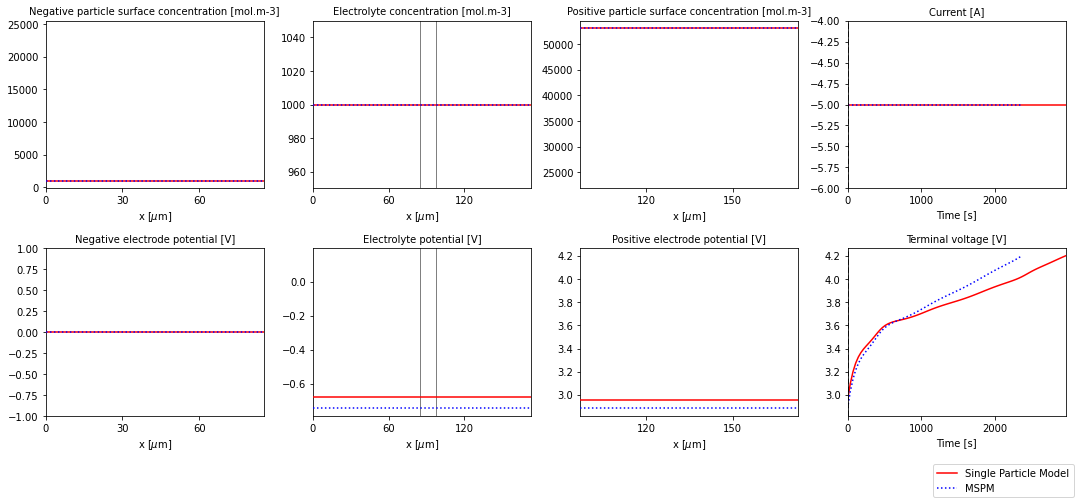

In [ ]:
sols1 =[]
for model in models:
    parameter_values["Current function [A]"] = -5
    sim1 = pybamm.Simulation(model, parameter_values=parameter_values)
    sol1 = sim1.solve([0, 3600])
    sols1.append(sol1)
pybamm.dynamic_plot(sols1)

[2] Solving SPM and MPM (chemomechanical model): for C/5, 1C and 2C C-rates charge

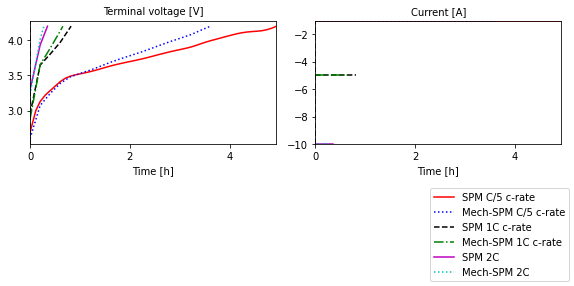

In [ ]:
sols2 =[]
A = np.array([5/5, 5, 2*5]);
for i in A:
    for model in models:
        parameter_values["Current function [A]"] = -i
        sim = pybamm.Simulation(model, parameter_values=parameter_values)
        sol2 = sim.solve([0, 72000])
        sols2.append(sol2)
        output_variables1 = ["Current [A]"]
        output_variables2 = ["Terminal voltage [V]"]
##        pybamm.dynamic_plot(sols,output_variables=output_variables1)
##        pybamm.dynamic_plot(sols,output_variables=output_variables2)
##        pybamm.dynamic_plot(sols)
output_variables2 = ["Terminal voltage [V]", "Current [A]"]
pybamm.dynamic_plot(sols2,output_variables=output_variables2, labels=["SPM C/5 c-rate", "Mech-SPM C/5 c-rate","SPM 1C c-rate", "Mech-SPM 1C c-rate","SPM 2C", "Mech-SPM 2C"])

[3] SPM and chemomechanical model: Charge for half an hour with 1C C-rate and then rest for half an hour cahrge



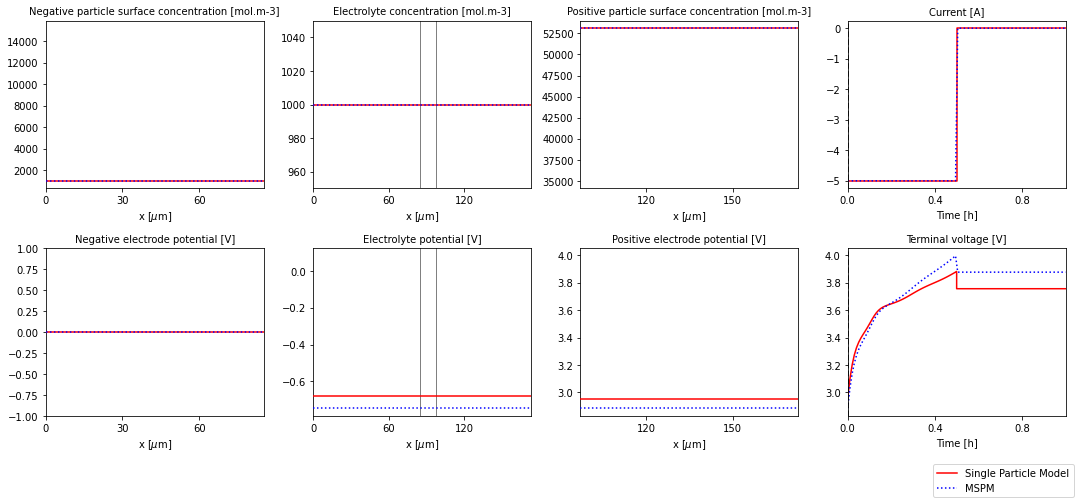

In [ ]:
tend = 3600 # [s]
t_cutoff = tend / 2  # [s]
t_rest = t_cutoff + 1  # [s]

t_eval = np.arange(0,tend,1)
I_typ = parameter_values["Typical current [A]"]  # current for 1C
def current(t):
    c_rate = 1;
    return - I_typ * c_rate * pybamm.EqualHeaviside(t, t_cutoff) 

parameter_values["Current function [A]"] = current
sols3=[]
for model in models:
    sim3 = pybamm.Simulation(model, parameter_values=parameter_values)
    sol3 = sim3.solve([0, 3600])
    sols3.append(sol3)
pybamm.dynamic_plot(sols3)
 




# THE END